# Analysis fastReach 

## general prep

In [2]:

# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
# %load_ext rpy2.ipython # currently not needed
import glob

from wordcloud import WordCloud, STOPWORDS
#from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pymer4 as pymer4
   


In [3]:
# set path
d = "C://Users/terfu/Desktop/2021-fastReach/analyses/Leonie_tests/" # for test data

p = "//stor1.bpn.tu-berlin.de/projects/Lukas_Gehrke/2021-fastReach/data/study/" #server for data access
pp = "C://Users/terfu/Desktop/2021-fastReach/data/study/" #repository for output

## load functions

In [4]:
from LT_plotting_funcs import *

# 1. Intentional Binding


### load data

In [18]:
# load data
behavior = pd.read_csv( p + 'PI_results.csv')

# set data types
behavior[['ed','rt']] = behavior[['ed','rt']].apply(pd.to_numeric, axis=1)

behavior['rd'] = behavior['rd'].astype("string")  # needs to be string before category for R conversion

behavior[['rd','condition']] = behavior[['rd','condition']].astype("category")


### plot only one condition

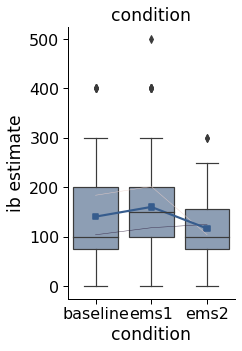

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [20]:
# with only stimulation condition
behavior_means = behavior.groupby(['id','condition'],as_index=False)['ed'].mean()

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','random','EEG'] 
ylabel = 'ib estimate'
xlabel = 'condition'
title = 'condition'
data = behavior
data_means = behavior_means
y = "ed"
x = "condition"
hue = "id"


plot_3_cats(data, x, y, hue, ylabel, xlabel,cats,palette,data_means)

### plot both conditions

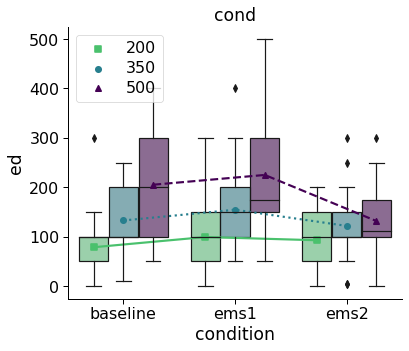

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [22]:
# with stimulation condition + time condition+ rd as y
behavior_means = behavior.groupby(['id','condition','rd'],as_index=False)['ed'].mean()


palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','ems1','ems2'] 
ylabel = 'ed'
xlabel = 'condition'
title = 'cond'
data = behavior
data_means = behavior_means
y = "ed"
x = "condition"
hue = "id"
hue2 = 'rd'


plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2)

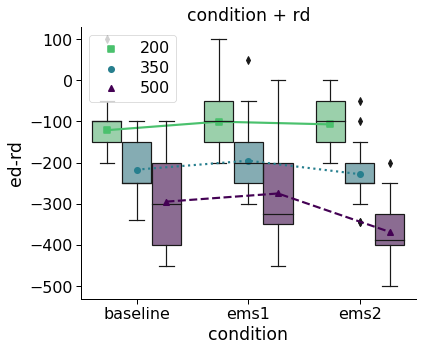

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
# with stimulation condition + time condition+ rd as y

behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
behavior["diff"]= behavior["ed"]-behavior["rd"]
behavior[['rd']] = behavior[['rd']].astype("category")


behavior_means = behavior.groupby(['id','condition','rd'],as_index=False)['diff'].mean()

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','ems1','ems2'] 
ylabel = 'ed-rd'
xlabel = 'condition'
title = 'condition + rd'
data = behavior
data_means = behavior_means
y = "diff"
x = "condition"
hue = "id"
hue2 = 'rd'


plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2)

histogramm rt

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


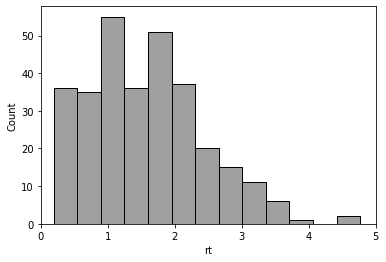

In [24]:

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'rt',color= 'grey',ax =ax)
ax.set_xlim(0,5) # remove outliers for visualization

hist.figure.savefig(d+'results/hist_rt.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
hist.figure.savefig(d+'results/hist_rt.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

### linear mixed model

#### prep
- witched from rpy2 to pymer4, because it is less annoying with importing / exporting from python to R
- not sure if of this is still necessary, but since pymer4 is based on rpy2, this might be the case

In [25]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x00000203B6C47E80> [RTYPES.NILSXP]

In [26]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))
from pymer4.models import Lmer

R[write to console]: Installiere Pakete nach 'C:/Users/terfu/AppData/Local/R/win-library/4.2'
(da 'lib' nicht spezifiziert)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/lme4_1.1-32.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 4515201 bytes (4.3 MB)

R[write to console]: downloaded 4.3 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/lmerTest_3.1-3.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 530338 bytes (517 KB)

R[write to console]: downloaded 517 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/emmeans_1.8.5.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2164948 bytes (2.1 MB)

R[write to console]: downloaded 2.1 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/geepack_1.3.9.zip'

R[write to console]

Paket 'lme4' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'lmerTest' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'emmeans' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'geepack' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'sjPlot' erfolgreich ausgepackt und MD5 Summen abgeglichen




Exception ignored from cffi callback <function _consolewrite_ex at 0x00000203B6C1A5F0>:
Traceback (most recent call last):
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 25: invalid continuation byte


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ed~condition*rd+(1|id)

Family: gaussian	 Inference: parametric

Number of observations: 309	 Groups: {'id': 2.0}

Log-likelihood: -1790.338 	 AIC: 3602.677

Random effects:

                 Name       Var     Std
id        (Intercept)   901.471  30.025
Residual               6183.558  78.636

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),80.219,31.995,128.442,24.604,3.301,3.260,0.041,*
condition1,19.156,-15.309,53.622,17.585,307.002,1.089,0.277,
condition2,16.835,-24.706,58.376,21.195,307.008,0.794,0.428,
rd1,56.496,21.806,91.186,17.699,307.008,3.192,0.002,**
rd2,127.063,93.206,160.920,17.274,306.999,7.356,0.000,***
condition1:rd1,-2.812,-52.037,46.414,25.116,307.013,-0.112,0.911,
condition2:rd1,-30.246,-89.131,28.639,30.044,307.016,-1.007,0.315,
condition1:rd2,-0.722,-48.883,47.439,24.572,306.998,-0.029,0.977,
condition2:rd2,-81.088,-137.609,-24.566,28.838,307.030,-2.812,0.005,**


<AxesSubplot:xlabel='Estimate'>

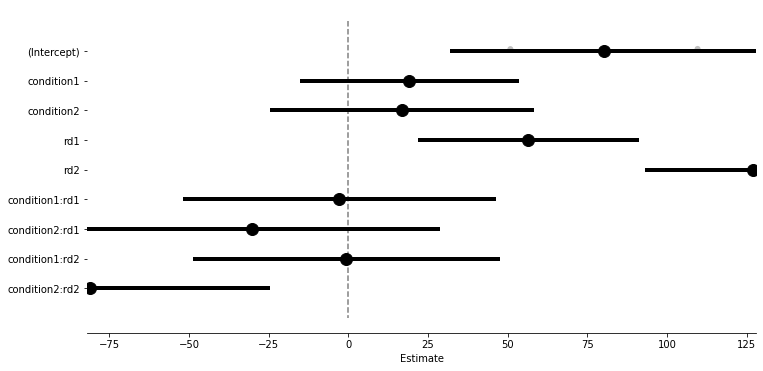

In [27]:
# does not run with one pID (RRuntimeError: Error: grouping factors must have > 1 sampled level)

full_model = Lmer('ed ~ condition * rd + (1|id)', data = behavior)
display(full_model.fit(REML = False,factors={"condition": ["baseline", "ems1", "ems2"], "rd": ["200", "350", "500"]}))
full_model.plot_summary()

#### define null models

In [28]:
# null without interaction
null_model_int = Lmer('ed ~ condition + rd + (1|id)', data = behavior)
null_model_int.fit(REML = False, summarize=False)

# null model without stimulation condition 
null_model_stim = Lmer('ed ~ rd + (1|id)', data = behavior)
null_model_stim.fit(REML = False, summarize=False)

# null model without temp condition 
null_model_temp = Lmer('ed ~ condition + (1|id)', data = behavior)
null_model_temp.fit(REML = False, summarize=False)


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are

#### liklyhood ratio tests
To DO: discussed before but: when we have a full model with interaction, 
what do we use as null models for liklyhood ration test? When we leave the interaction out compleatly,
 we can not use the ß estimates from the full model (Ithink)


interaction

In [29]:
pymer4.stats.lrt([null_model_int,full_model])


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ed~condition+rd+(1|id),7,3604.468479,3630.601868,-1795.234240,3590.468479,,,,
1,ed~condition*rd+(1|id),11,3602.676530,3643.743284,-1790.338265,3580.676530,9.791949,4.0,0.044082,*


stimulation condition

In [30]:
pymer4.stats.lrt([null_model_stim,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ed~rd+(1|id),5,3611.559176,3630.225882,-1800.779588,3601.559176,,,,
1,ed~condition*rd+(1|id),11,3602.676530,3643.743284,-1790.338265,3580.676530,20.882646,6.0,0.001926,**


temp condition

In [31]:
pymer4.stats.lrt([null_model_temp,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ed~condition+(1|id),5,3685.492505,3704.159212,-1837.746253,3675.492505,,,,
1,ed~condition*rd+(1|id),11,3602.676530,3643.743284,-1790.338265,3580.676530,94.815975,6.0,0.0,***


#### post hoc test

TODO check wether this post_hoc test is correct

In [186]:
# post hoc test stimulation condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="condition",p_adjust = "bonf")

print(comparisons)


P-values adjusted by bonf method for 3 comparisons
            Contrast  Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val  \
1     baseline - eeg     4.208   2.736    5.680  0.606  118.0   6.944    0.0   
2  baseline - random     7.009   5.537    8.481  0.606  118.0  11.565    0.0   
3       eeg - random     2.801   1.329    4.273  0.606  118.0   4.622    0.0   

   Sig  
1  ***  
2  ***  
3  ***  


In [187]:
# post hoc test stimulation condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="rd",p_adjust = "bonf")

print(comparisons)

P-values adjusted by bonf method for 3 comparisons
        Contrast  Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
1  rd200 - rd250    -0.086  -1.524    1.352  0.592  118.0  -0.145    1.0    
2  rd200 - rd500     0.220  -1.218    1.658  0.592  118.0   0.371    1.0    
3  rd250 - rd500     0.306  -1.232    1.843  0.633  118.0   0.483    1.0    


# 2. EEG Data

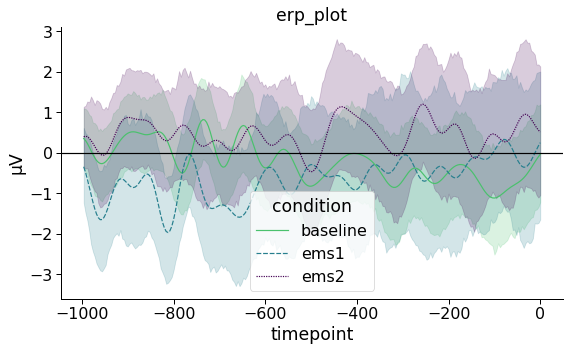

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


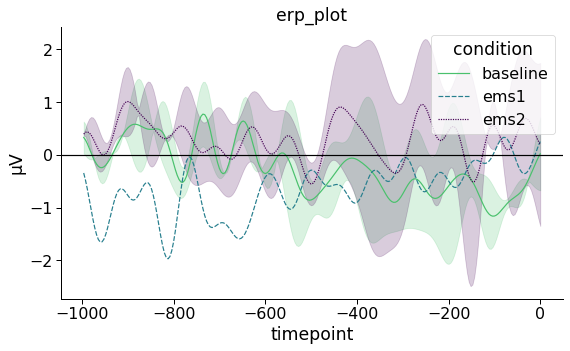

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [5]:
eeg_data = pd.read_csv( p +'PI_results.csv')

data = eeg_data
id_vars = ['id','condition','tr_nr','rd','ed']
id_vars_2 = ['id','condition']
delete_vars = 'rt' # metrics that are not erp
sample_rate = 250
window_start = -1000 
hue = 'condition'
palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
title = 'erp_plot'
data_2 = eeg_data.groupby(['id','condition'],as_index=False)[eeg_data.columns[eeg_data.columns.str.contains(pat = 'erp')]].mean()

#plotting based on single trials ( e.g. when only plotting one person)
plot_erp_timeline(data,id_vars,delete_vars,sample_rate,window_start,hue,palette,title)

#plotting based on mean values for pID
plot_erp_timeline_2(data_2, id_vars_2,sample_rate,window_start,hue,palette,title)
 

# 2. Questionaire results
- items per block "„Während der Aufgabe hat es sich angefühlt, als hätte ich die Kontrolle über die Bewegungen.“
- input pid|first_block|control_random|control_EEG|expectation_fit|embodiment
- paired t-testsf
- box plots
- SD,M,effect size

@ Lukas? Significance test mit 5 values ist wirklich etwas shady, oder?

In [23]:
#laod fake data
questionaire= pd.read_csv('fake_data/subjective_fastReach.csv', sep = ';')

In [30]:
questionaire= pd.read_excel(pp + 'questionaire.xlsx') #read from repository


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


### plot control

control_agency vs. control_random: Custom statistical test, P_val:nan


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


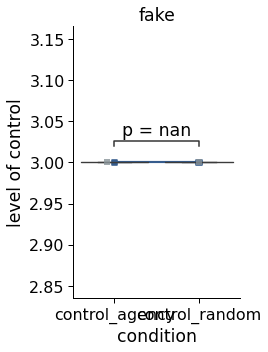

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [33]:
questionaire_long = questionaire.melt(id_vars= ['pID'],value_vars=['control_agency','control_random'])

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['control_random', 'control_agency']
ylabel = 'level of control'
xlabel = 'condition'
title = 'fake'
data = questionaire_long
y = "value"
x = "variable"
hue = "pID"

plot_2_cats(data, x, y, hue, ylabel, xlabel,cats,palette)

#cohend(data,x,y, cats)

### numbers control

In [34]:
questionaire_long.groupby('variable')['value'].agg(["mean", "std"])


,mean,std
variable,,
control_agency,3.0,NaN
control_random,3.0,NaN


### count expectation

In [35]:
questionaire['expectation_fit'].value_counts()

KeyError: 'expectation_fit'

### count embodiment

In [108]:
questionaire['embodiment'].value_counts()

nein    11
ja      11
Name: embodiment, dtype: int64

# 3. Content Analysis
- built to world clouds for each block
- define stopwords
- maybe check sentiment analysis -> pareid t-test?
-TODO: try word cloud german


In [459]:
interview_random_text = questionaire['interview_random'].to_json()

interview_eeg_text = questionaire['interview_EEG'].to_json()

stopwords = STOPWORDS # extend by domaine specific words if necessary



In [460]:
wc_formate = WordCloud(background_color='black', max_words=500, width=3000,
                    height=1500, stopwords=stopwords, min_font_size=2,
                    contour_width=3, contour_color='white')

wc_formate.generate(interview_random_text)
wc_formate.to_file((d+"results/wordcloud_random.png"))

wc_formate.generate(interview_eeg_text)
wc_formate.to_file((d+"results/wordcloud_eeg.png"))


# 4. Sentiment Analysis

In [463]:
# for whole text

analyzer=SentimentIntensityAnalyzer()  

print(analyzer.polarity_scores(interview_random_text))
print(analyzer.polarity_scores(interview_eeg_text))



{'neg': 0.049, 'neu': 0.809, 'pos': 0.142, 'compound': 0.9846}
{'neg': 0.104, 'neu': 0.735, 'pos': 0.161, 'compound': 0.9879}
